In [1]:
import xspec
from xspec import *
import numpy as np
import matplotlib.pyplot as plot1
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import os
import signal

Photon Index1: 0.38332171171424123
Photon Index2: 1.9640077830672251

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/5/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.969e-01 +/- 4.310e-02 (90.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-260
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 294.5 sec
 Using fit statistic: chi
 Using Background File                ./em01_008147_020_BackgrSpec_00006_c010.fits
  Background Exposure Time: 294.5 sec
 Using Response (RMF) File            ./em01_008147_020_RMF_00006_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_008147_020_ARF_00006_c010.fits


Model bknpower<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   bknpower   PhoIndx1            1.00000      +/-  0.0          
   2    1   bknpower   BreakE     keV      5.00000      +/-  0.0          
   3    1   bknpow

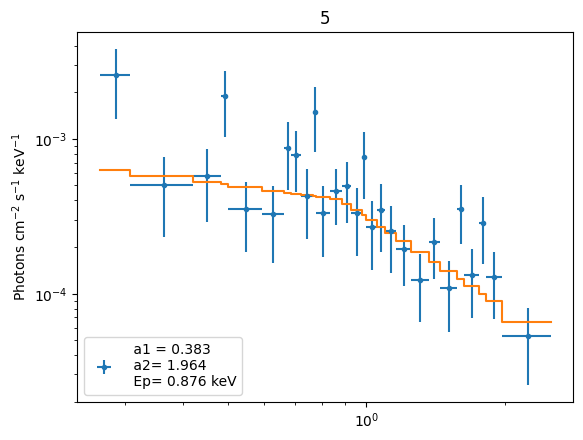


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/6/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.146e-01 +/- 3.607e-02 (90.6 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-286
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 436.8 sec
 Using fit statistic: chi
 Using Background File                ./em01_024126_020_BackgrSpec_00002_c010.fits
  Background Exposure Time: 436.8 sec
 Using Response (RMF) File            ./em01_024126_020_RMF_00002_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_024126_020_ARF_00002_c010.fits


Fit statistic  : Chi-Squared                  281.29     using 286 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  281.29     using 286 bins.

***Warning: Chi-square may not be valid due to bins with zero 

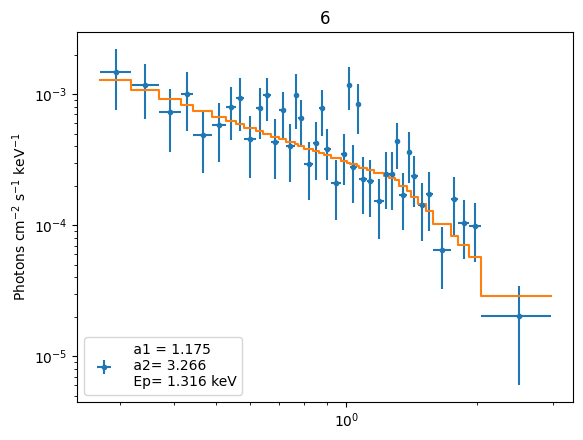


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/7/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.167e+00 +/- 5.291e-02 (94.1 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-276
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 443.4 sec
 Using fit statistic: chi
 Using Background File                ./em01_048123_020_BackgrSpec_00001_c010.fits
  Background Exposure Time: 443.4 sec
 Using Response (RMF) File            ./em01_048123_020_RMF_00001_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_048123_020_ARF_00001_c010.fits


Fit statistic  : Chi-Squared                  426.82     using 276 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  426.82     using 276 bins.

***Warning: Chi-square may not be valid due to bins with zero 


*** Warning: User interrupted fit, fit not valid.


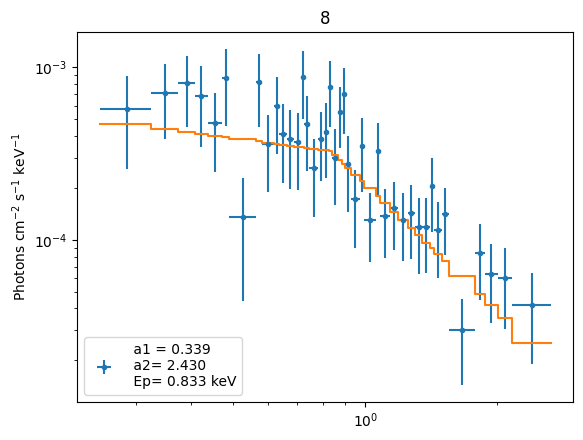


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/9/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.465e-01 +/- 2.889e-02 (89.7 % total)
Photon Index1: 0.46536353999385266
Photon Index2: 2.6675938527778147
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-397
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 463.4 sec
 Using fit statistic: chi
 Using Background File                ./em01_052117_020_BackgrSpec_00002_c010.fits
  Background Exposure Time: 463.4 sec
 Using Response (RMF) File            ./em01_052117_020_RMF_00002_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_052117_020_ARF_00002_c010.fits


Fit statistic  : Chi-Squared                  475.48     using 397 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  475.48     using 397 

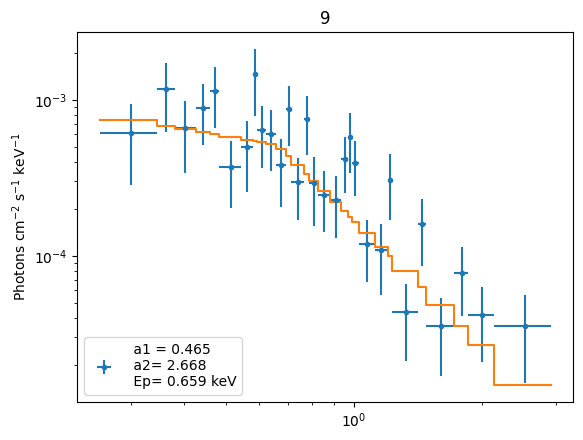


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/10/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.146e-01 +/- 5.527e-02 (91.4 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-593
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 220.2 sec
 Using fit statistic: chi
 Using Background File                ./em01_059090_020_BackgrSpec_00003_c010.fits
  Background Exposure Time: 220.2 sec
 Using Response (RMF) File            ./em01_059090_020_RMF_00003_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_059090_020_ARF_00003_c010.fits


Fit statistic  : Chi-Squared                  610.39     using 593 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  610.39     using 593 bins.

***Warning: Chi-square may not be valid due to bins with zero

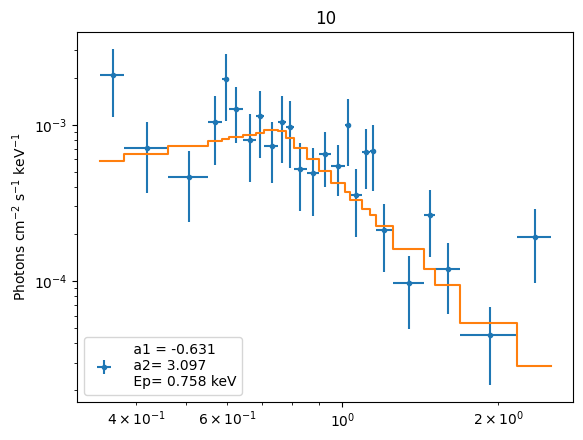


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/11/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.138e+00 +/- 5.834e-02 (95.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-294
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 655.5 sec
 Using fit statistic: chi
 Using Background File                ./em01_059129_020_BackgrSpec_00002_c010.fits
  Background Exposure Time: 655.5 sec
 Using Response (RMF) File            ./em01_059129_020_RMF_00002_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_059129_020_ARF_00002_c010.fits


Fit statistic  : Chi-Squared                  872.26     using 294 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  872.26     using 294 bins.

***Warning: Chi-square may not be valid due to bins with zero

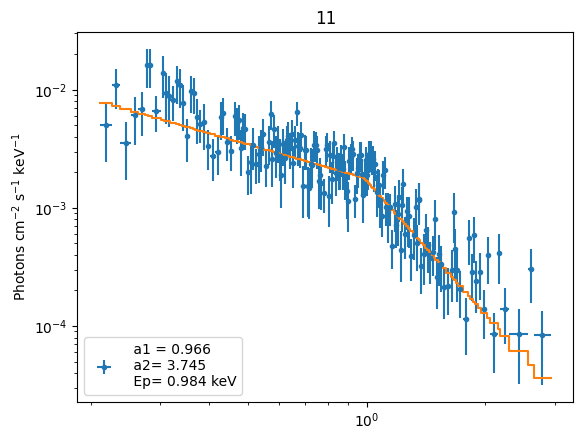


Spectrum #: 1 replaced 
Photon Index1: 1.1306606726090112
Photon Index2: 1.800413952220903

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/12/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.264e-01 +/- 3.339e-02 (91.3 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-266
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 419.4 sec
 Using fit statistic: chi
 Using Background File                ./em01_077120_020_BackgrSpec_00005_c010.fits
  Background Exposure Time: 419.4 sec
 Using Response (RMF) File            ./em01_077120_020_RMF_00005_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_077120_020_ARF_00005_c010.fits


Fit statistic  : Chi-Squared                 2889.19     using 266 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                 2889.19     using 266 b

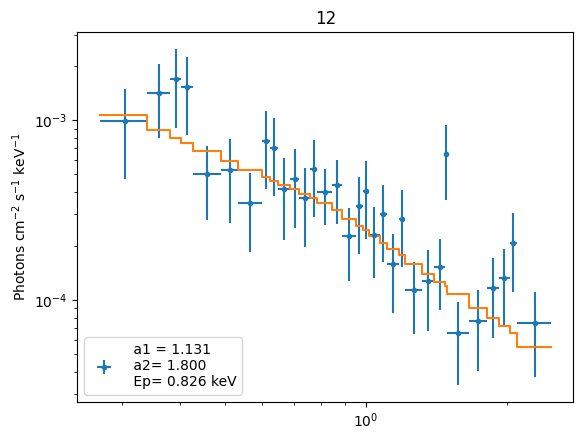


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/13/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.888e-01 +/- 5.269e-02 (93.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-343
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 341.8 sec
 Using fit statistic: chi
 Using Background File                ./em01_079114_020_BackgrSpec_00001_c010.fits
  Background Exposure Time: 341.8 sec
 Using Response (RMF) File            ./em01_079114_020_RMF_00001_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_079114_020_ARF_00001_c010.fits


Fit statistic  : Chi-Squared                  415.06     using 343 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  415.06     using 343 bins.

***Warning: Chi-square may not be valid due to bins with zero


*** Warning: User interrupted fit, fit not valid.


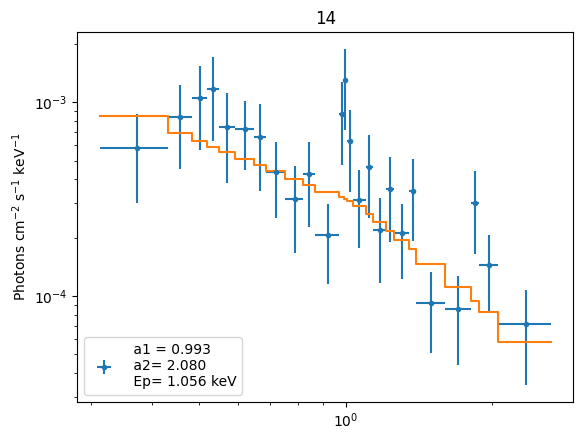


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/15/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.734e-01 +/- 5.316e-02 (92.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-462
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 218.6 sec
 Using fit statistic: chi
 Using Background File                ./em01_083072_020_BackgrSpec_00004_c010.fits
  Background Exposure Time: 218.6 sec
 Using Response (RMF) File            ./em01_083072_020_RMF_00004_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_083072_020_ARF_00004_c010.fits

Photon Index1: 1.5643033643371644
Photon Index2: 0.2891938836661972

Fit statistic  : Chi-Squared                  419.23     using 462 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  419.23     using 462 

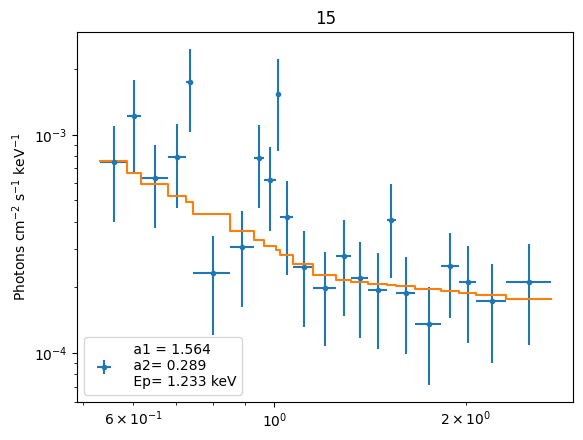

Photon Index1: 0.19966759442027537
Photon Index2: 2.01812439229448

Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/16/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.269e+00 +/- 7.601e-02 (94.5 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-427
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 232.5 sec
 Using fit statistic: chi
 Using Background File                ./em01_083090_020_BackgrSpec_00004_c010.fits
  Background Exposure Time: 232.5 sec
 Using Response (RMF) File            ./em01_083090_020_RMF_00004_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_083090_020_ARF_00004_c010.fits


Fit statistic  : Chi-Squared                 1080.11     using 427 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                 1080.11     using 427 b

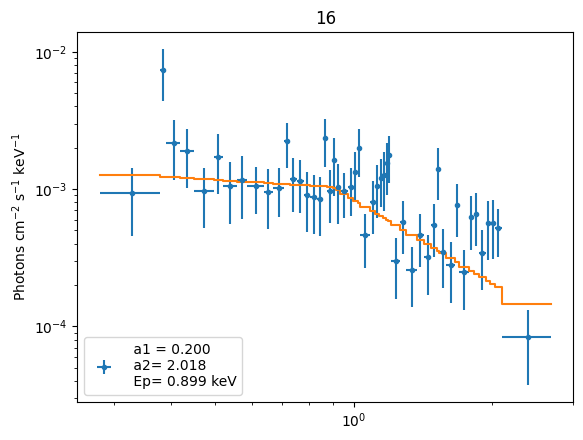


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/17/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.522e+00 +/- 8.119e-02 (97.2 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-564
Photon Index1: -2.1233626536418537
Photon Index2: 1.7381614444905962
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 237.6 sec
 Using fit statistic: chi
 Using Background File                ./em01_083096_020_BackgrSpec_00003_c010.fits
  Background Exposure Time: 237.6 sec
 Using Response (RMF) File            ./em01_083096_020_RMF_00003_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_083096_020_ARF_00003_c010.fits


Fit statistic  : Chi-Squared                  509.19     using 564 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  509.19     using 564

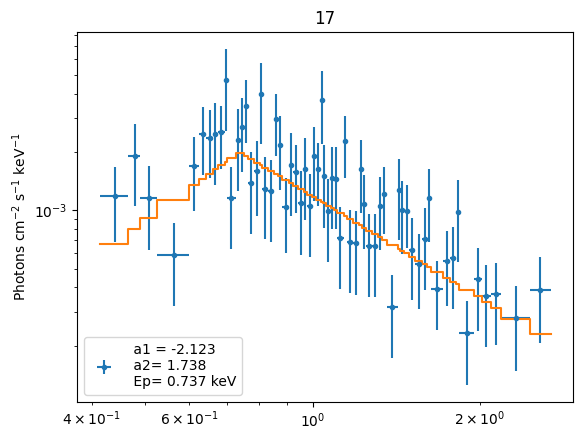


Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/18/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.295e-01 +/- 5.472e-02 (93.7 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-482
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 224.7 sec
 Using fit statistic: chi
 Using Background File                ./em01_083096_020_BackgrSpec_00015_c010.fits
Photon Index1: -0.7641872337834991
Photon Index2: 2.0939361190138075
  Background Exposure Time: 224.7 sec
 Using Response (RMF) File            ./em01_083096_020_RMF_00015_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./em01_083096_020_ARF_00015_c010.fits


Fit statistic  : Chi-Squared                  639.37     using 482 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  639.37     using 482

In [ ]:
#Plotting all the energy spectra using the looping
base_dir = "/media/abhi/Data/Data/Galactic_transients"  
save_dir = "/media/abhi/Data/Data/Galactic_transients/All"

#Defining the exception
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

signal.signal(signal.SIGALRM, timeout_handler)


for i in range(5,200):
    folder = os.path.join(base_dir, str(i))
    file_path = os.path.join(folder, "spec_grp_1.pi")
    #plot_file = os.path.join(save_dir, f"spec_{i}.png")

    os.chdir(folder)  
    xspec.AllData(file_path)
    #xspec.Plot.device = f"{plot_file} /png"
    xspec.Plot.xAxis = "keV"
    xspec.Plot("data")
    

    try:
        #Fitting model (broken Power law) and initial parameters
        model = xspec.Model("bknpower")
        xspec.AllData.ignore("**-0.2 3.0-**")

        #initiate params
        model.bknpower.PhoIndx1 = 1
        model.bknpower.BreakE = 1
        model.bknpower.PhoIndx2 = 2
        model.bknpower.norm = 1

        #Fit
        #signal.alarm(5)
        xspec.Fit.perform()
        
        # Print parameter values
        a1 = model.bknpower.PhoIndx1.values[0]
        a2 = model.bknpower.PhoIndx2.values[0]
        Ep = model.bknpower.BreakE.values[0]
        print("Photon Index1:", a1)
        print("Photon Index2:", a2)
                
        #Plotting
        Plot("ufspec")
        energies = Plot.x()
        edeltas = Plot.xErr()
        rates = Plot.y(1,1)
        errors = Plot.yErr(1,1)
        foldedmodel = Plot.model()
        dataLabels = Plot.labels(1)
        
        nE = len(energies)
        stepenergies = [energies[i] - edeltas[i] for i in range(nE)]
        stepenergies.append(energies[-1] + edeltas[-1])
        foldedmodel_plot = foldedmodel.copy()
        foldedmodel_plot.append(foldedmodel_plot[-1])

        #Plotting
        #plot1.figure(figsize=(8, 6))
        plot1.xscale('log')
        plot1.yscale('log')
        plot1.ylabel(dataLabels[1])
        plot1.title(f"{i}")
        plot1.errorbar(energies, rates, xerr=edeltas, yerr=errors, fmt='.', label = f" a1 = {a1:.3f}\n a2= {a2:.3f}\n Ep= {Ep:.3f} keV")
        plot1.step(stepenergies, foldedmodel_plot, where='post')
        plot1.legend(loc='lower left')
        #plot1.savefig(os.path.join(save_dir, f"{i}.png"), dpi=300)
        plot1.show()
        plot1.close()
                
        
        signal.alarm(0)
        
    except TimeoutException:
        print(f"Timeout: Skipping folder {i}")
        continue
    
    except Exception as e:
        print(f"Error in folder {i}: {e}")
        continue        
    
    finally:
        signal.alarm(0)  

In [ ]:
xspec.model.Model("bknpower")


Model bknpower<1> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   bknpower   PhoIndx1            1.00000      +/-  0.0          
   2    1   bknpower   BreakE     keV      5.00000      +/-  0.0          
   3    1   bknpower   PhoIndx2            2.00000      +/-  0.0          
   4    1   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________

